## GL Points and DOTS Refitting & Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib import pyplot
pyplot.rcParams['figure.dpi'] = 100
pyplot.rcParams['savefig.dpi'] = 300

In [2]:
old_coef = [610.32796, 1045.59282, 0.03048]
bwts = np.linspace(45, 170, 1000)

def ipf_formula(bwt, A, B, C):
    return (A - B * np.exp(-C * bwt))

### Refitting GL Points on new data

In [3]:
data = pd.read_csv("female data/gold_standardfemale_data_ipf_epf.csv")
popt, pcov = curve_fit(ipf_formula, data['BodyweightKg'].values, data['TotalKg'], p0=old_coef)
new_coef = popt

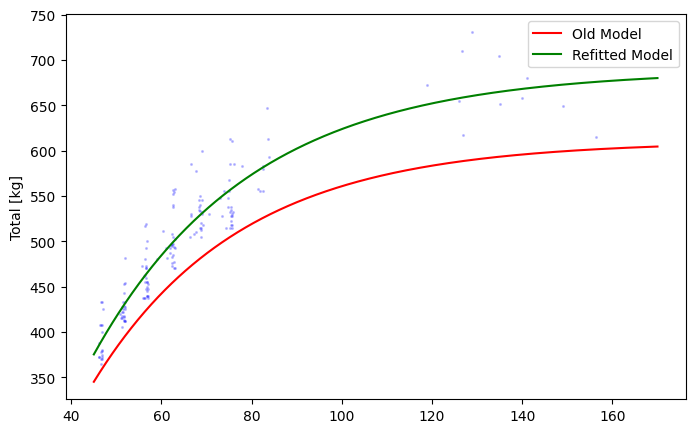

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(bwts, ipf_formula(bwts, *old_coef), c = 'r', label='Old Model')
plt.plot(bwts, ipf_formula(bwts, *new_coef),  c = 'g', label='Refitted Model')
plt.scatter(data['BodyweightKg'].values, data['TotalKg'], alpha=0.2, s = 1.5, color="blue")
plt.ylabel("Total [kg]")
plt.legend()

Converting this expected total to the GL coefficients and plotting them.

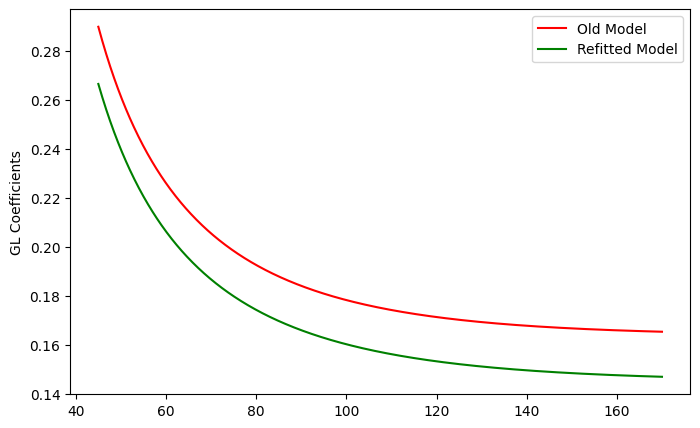

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(bwts, 100 / ipf_formula(bwts, *old_coef), c = 'r', label='Old Model')
plt.plot(bwts, 100 / ipf_formula(bwts, *new_coef),  c = 'g', label='Refitted Model')
plt.ylabel("GL Coefficients")
plt.legend()

Now we can look at the expected change in GL points due to refitting for a given bodyweigh. Note that this will be the same regardless of the total obtained, as the final score is just multiplied with the total.

Text(0, 0.5, '% change in GL Points due to refitting')

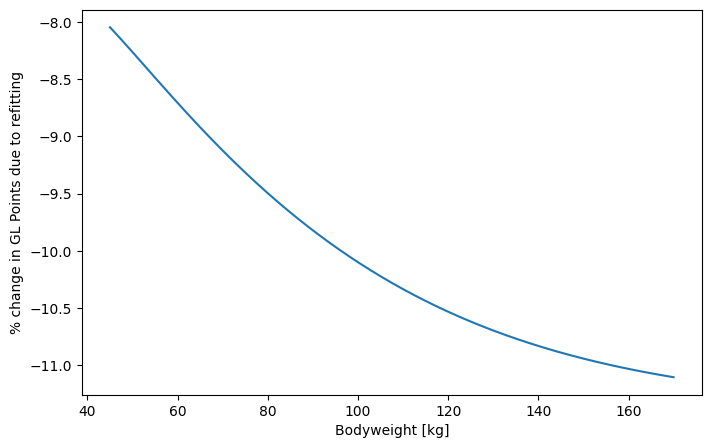

In [6]:
relative_diff = (100 / ipf_formula(bwts, *new_coef)) /  \
    (100 / ipf_formula(bwts, *old_coef))
plt.figure(figsize=(8, 5))
plt.plot(bwts, 100 * (relative_diff-1))
plt.xlabel("Bodyweight [kg]")
plt.ylabel("% change in GL Points due to refitting")

### Weight Class Analysis
Looking at the distribution of the GL points in the weight classes and its changes due to refitting. We look at the entire dataset so we have a (relatively) unbiased sample.

In [7]:
data_full = pd.read_csv("female data/females_filtered_data_ipf_epf.csv")

In [8]:
data_full['GLold'] = data_full['TotalKg'] * (100 / ipf_formula(data_full['BodyweightKg'], *old_coef))
data_full['GLnew'] = data_full['TotalKg'] * (100 / ipf_formula(data_full['BodyweightKg'], *new_coef))

In [9]:
data['GLold'] = data['TotalKg'] * (100 / ipf_formula(data['BodyweightKg'], *old_coef))
data['GLnew'] = data['TotalKg'] * (100 / ipf_formula(data['BodyweightKg'], *new_coef))

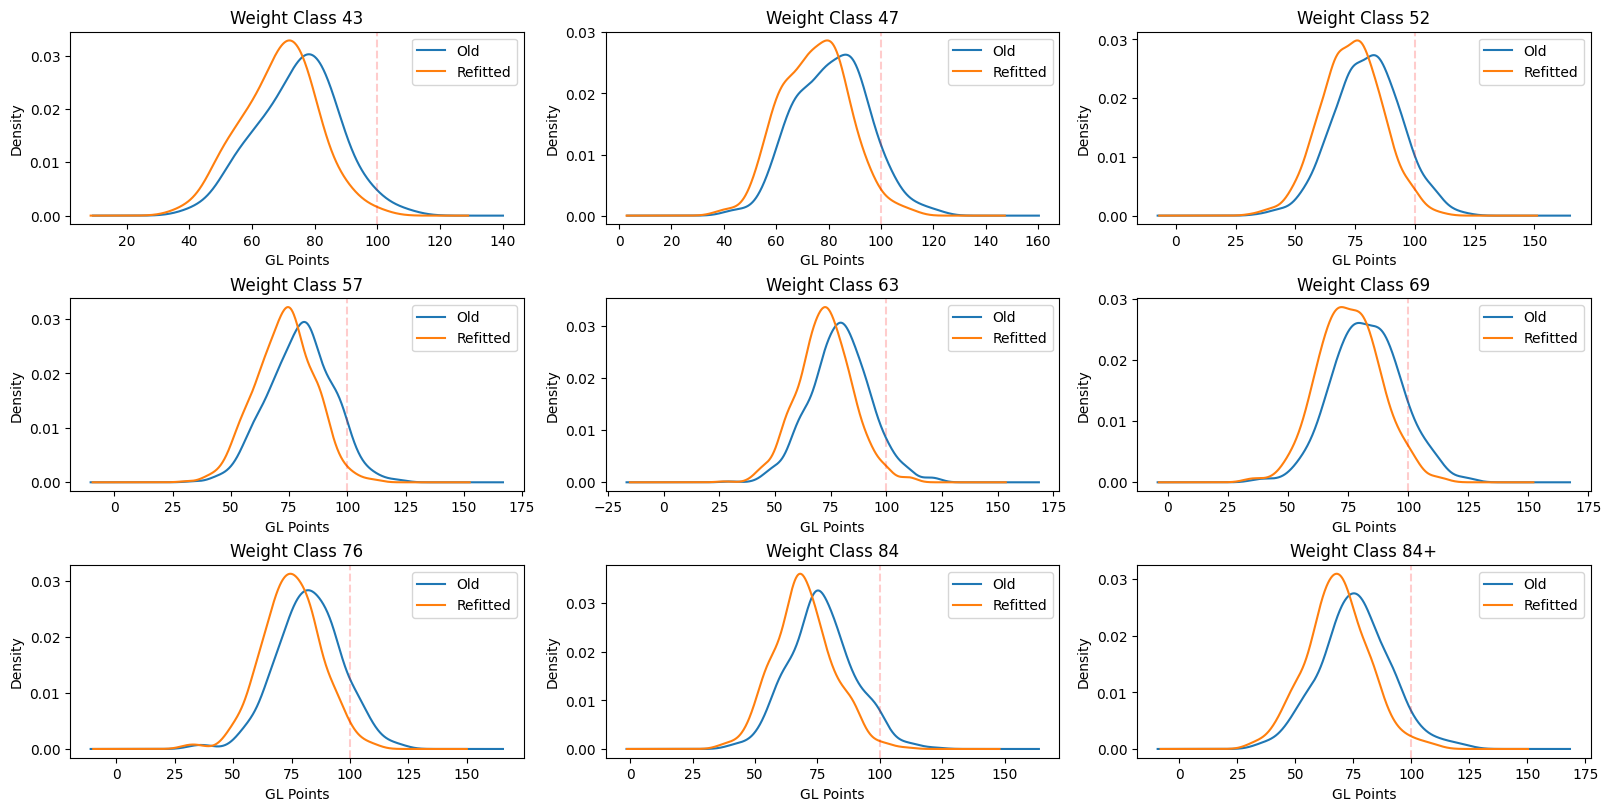

In [10]:
import matplotlib.pyplot as plt

selected_weight_classes = ['47', '52', '57', '63', '69', '76', '84', '84+', '43']

# Filter the data to include only the selected weight classes
data_filtered = data_full[data_full['WeightClassKg'].isin(selected_weight_classes)]

# Define the grid dimensions (here 9 weightclasses, so 3x3)
rows, cols = 3, 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 8), constrained_layout=True)

axes = axes.flatten()

for ax, (weight_class, group) in zip(axes, data_filtered.groupby('WeightClassKg')):
    group = group.dropna(subset=['GLold', 'GLnew'])

    if group.empty:
        continue
    group['GLold'].plot(kind='kde', ax=ax, label = 'Old')
    group['GLnew'].plot(kind='kde', ax=ax, label = 'Refitted')
    ax.axvline(100, ymin = 0, color = 'red', linestyle = 'dashed', alpha = 0.2)
    ax.set_title(f'Weight Class {weight_class}')
    ax.set_xlabel('GL Points')
    ax.set_ylabel('Density')
    ax.legend()

# Show the plots
plt.show()


We see the distributions become fairer, as we generally want the distribution to be symmetric around 100 (given an ideal data split). They aren't very symmetric, but the volume of probability at either sides does tend to be more equal with the refitted variant. This does show the (on average) favoured weight classes by this formula (e.g. 93).

In [11]:
import pandas as pd

# Load the data
data_all = pd.read_csv(
    'female data/all_meets_female_ipf_epf.csv',
    dtype={'BodyweightKg': 'float64', 'TotalKg': 'float64'},
    low_memory=False
)

# Calculate GLold and GLnew values
data_all['GLold'] = data_all['TotalKg'] * (100 / ipf_formula(data_all['BodyweightKg'], *old_coef))
data_all['GLnew'] = data_all['TotalKg'] * (100 / ipf_formula(data_all['BodyweightKg'], *new_coef))

# Filter data for specific meet
specific_meet = "World Classic Powerlifting Championships"
specific_date = "2024-06-15"

filtered_data = data_all[(data_all['MeetName'].str.contains(specific_meet, case=False, na=False)) &
                     (data_all['Date'] == specific_date)]
# Sort independently for GLold and GLnew
sorted_by_glold = filtered_data.sort_values(by='GLold', ascending=False)
sorted_by_glnew = filtered_data.sort_values(by='GLnew', ascending=False)

# Select the top 10 for each
top_10_glold = sorted_by_glold[['Name', 'TotalKg', 'WeightClassKg', 'MeetName', 'GLold']].head(50)
top_10_glnew = sorted_by_glnew[['Name', 'TotalKg', 'WeightClassKg', 'MeetName', 'GLnew']].head(50)

# Display the top 10 for GLold and GLnew
display(top_10_glold)
display(top_10_glnew)


,Name,TotalKg,WeightClassKg,MeetName,GLold
1100,sonita muluh,731.0,84+,world classic powerlifting championships,123.940989
1090,amanda lawrence #1,642.5,84,world classic powerlifting championships,121.852401
1072,agata sitko,613.0,76,world classic powerlifting championships,121.389085
1032,meghan scanlon,552.5,63,world classic powerlifting championships,121.376914
1012,jade jacob,515.0,57,world classic powerlifting championships,121.201437
1048,carola garra,577.5,69,world classic powerlifting championships,121.038049
992,evie corrigan,477.5,52,world classic powerlifting championships,120.872177
982,tiffany chapon,433.0,47,world classic powerlifting championships,120.538299
1101,brittany schlater,704.5,84+,world classic powerlifting championships,120.188945
1049,prescillia bavoil,567.5,69,world classic powerlifting championships,120.031987


,Name,TotalKg,WeightClassKg,MeetName,GLnew
1012,jade jacob,515.0,57,world classic powerlifting championships,110.820498
992,evie corrigan,477.5,52,world classic powerlifting championships,110.783499
982,tiffany chapon,433.0,47,world classic powerlifting championships,110.746201
1100,sonita muluh,731.0,84+,world classic powerlifting championships,110.704109
1032,meghan scanlon,552.5,63,world classic powerlifting championships,110.671838
1090,amanda lawrence #1,642.5,84,world classic powerlifting championships,110.151800
1048,carola garra,577.5,69,world classic powerlifting championships,110.110776
1072,agata sitko,613.0,76,world classic powerlifting championships,110.066560
1049,prescillia bavoil,567.5,69,world classic powerlifting championships,109.247030
1033,chiara bernardi,540.0,63,world classic powerlifting championships,108.226734


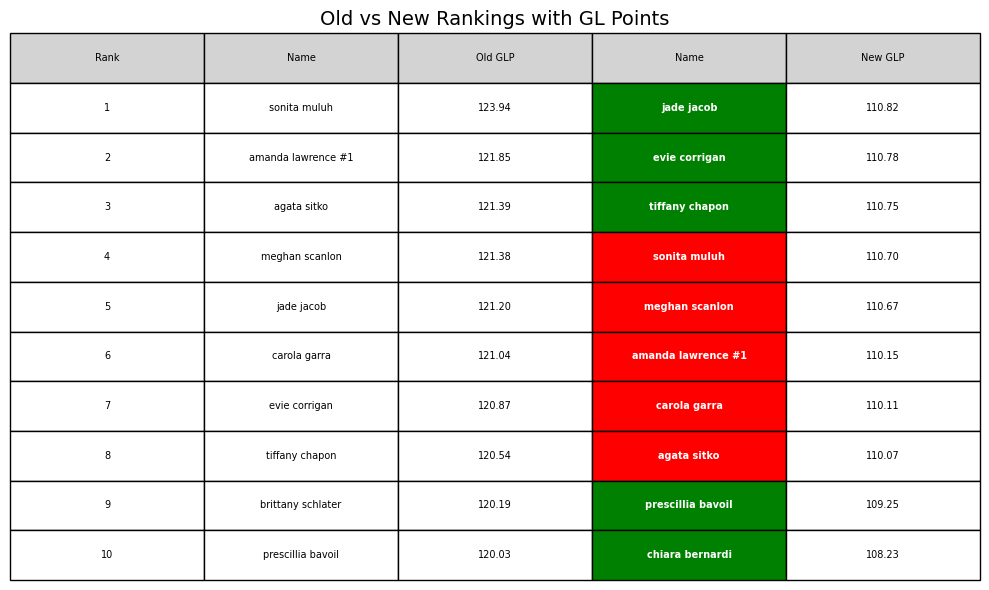

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Extract the names and GLP values
# Ensure top_10_glold and top_10_glnew are correctly sized
top_10_glold = top_10_glold.head(10).reset_index(drop=True)
top_10_glnew = top_10_glnew.head(10).reset_index(drop=True)

# Extract the names and GLP values
glold_names = top_10_glold['Name']
glold_glp = top_10_glold['GLold']

glnew_names = top_10_glnew['Name']
glnew_glp = top_10_glnew['GLnew']

# Create the comparison DataFrame
comparison = pd.DataFrame({
    'GLold_Ranking': range(1, 11),
    'GLold': glold_names,
    'GLold_GLP': glold_glp,
    'GLnew': glnew_names,
    'GLnew_GLP': glnew_glp
})


# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')  # Turn off axes for a clean table look

# Create the table
table = Table(ax, bbox=[0, 0, 1, 1])

# Column headers
columns = ["Rank", "Name", "Old GLP", "Name", "New GLP"]
for col_idx, col_name in enumerate(columns):
    table.add_cell(0, col_idx, width=0.2, height=0.05, text=col_name, loc='center', facecolor='lightgrey')

for i, row in comparison.iterrows():
    if row['GLnew'] not in comparison['GLold'].values:
        color = 'green'
        text_color = 'white'
        bg_color = 'green'
    else:
        old_rank = comparison[comparison['GLold'] == row['GLnew']].index[0]
        if old_rank > i:
            color = 'green'
            text_color = 'white'
            bg_color = 'green'
        elif old_rank < i:
            color = 'red'
            text_color = 'white'
            bg_color = 'red'
        else:
            bg_color = 'white'
            text_color = 'black'

    table.add_cell(i + 1, 0, width=0.2, height=0.05, text=f"{i + 1}", loc='center')

    table.add_cell(i + 1, 1, width=0.2, height=0.05, text=f"{row['GLold']}", loc='center')
    table.add_cell(i + 1, 2, width=0.2, height=0.05, text=f"{row['GLold_GLP']:.2f}", loc='center')

    new_cell = table.add_cell(i + 1, 3, width=0.2, height=0.05, text=f"{row['GLnew']}", loc='center', facecolor=bg_color)
    table.add_cell(i + 1, 4, width=0.2, height=0.05, text=f"{row['GLnew_GLP']:.2f}", loc='center')

    new_cell.set_text_props(fontweight='bold', color=text_color)

ax.add_table(table)

plt.title('Old vs New Rankings with GL Points', fontsize=14)

plt.tight_layout()
plt.show()


In [13]:
data_gl_rank =  pd.read_csv(
    'female data/all_meets_female_ipf_epf.csv',
    dtype={'BodyweightKg': 'float64', 'TotalKg': 'float64'},
    low_memory=False
)

data_gl_rank['GLold'] = data_gl_rank['TotalKg'] * (100 / ipf_formula(data_gl_rank['BodyweightKg'], *old_coef))
data_gl_rank['GLnew'] = data_gl_rank['TotalKg'] * (100 / ipf_formula(data_gl_rank['BodyweightKg'], *new_coef))


In [14]:
sorted_data = data_gl_rank.sort_values(by='GLold', ascending=False)
top_10_distinct = sorted_data.drop_duplicates(subset='Name', keep='first')

top_10_distinct = top_10_distinct.head(10)
display(top_10_distinct)

,Name,BodyweightKg,TotalKg,WeightClassKg,Federation,Date,MeetName,GLold,GLnew
15851,agata sitko,71.58,627.0,76,FFForce,2024-10-19,girl power,127.350966,115.652287
1100,sonita muluh,128.95,731.0,84+,IPF,2024-06-15,world classic powerlifting championships,123.940989,110.704109
1116,prescillia bavoil,66.46,585.0,69,IPF,2024-02-10,sheffield powerlifting championships,123.832369,112.710525
1122,jade jacob,56.57,519.5,57,IPF,2024-02-10,sheffield powerlifting championships,122.554688,112.067616
1117,carola garra,67.17,582.5,60,IPF,2024-02-10,sheffield powerlifting championships,122.537326,111.496155
1125,amanda lawrence #1,83.51,647.0,84,IPF,2024-02-10,sheffield powerlifting championships,122.466285,110.690039
1123,natalie richards #1,56.36,516.5,57,IPF,2024-02-10,sheffield powerlifting championships,122.192058,111.747395
1118,evie corrigan,51.85,481.0,52,IPF,2024-02-10,sheffield powerlifting championships,121.758151,111.595525
135164,meghan scanlon,64.30,562.5,69,AMP,2024-12-14,maine classic,121.483098,110.681288
15847,sara naldi,56.60,515.0,57,FFForce,2024-10-19,girl power,121.444279,111.050611


    ## Refitting DOTS
Repeating the same procedure for DOTS.

In [15]:
def dots(bwt, a, b, c, d, e):
    return (a + b * bwt + c * bwt**2 + d * bwt**3 + e * bwt**4)

dots_p0 = [-307.75076, 24.0900756, -0.1918759221, 0.0007391293, -0.000001093] 
# For men, see https://www.inchcalculator.com/lifting-strength-calculator/ for women
popt, pcov = curve_fit(dots, data['BodyweightKg'].values, data['TotalKg'], p0=dots_p0)
dots_coef = popt

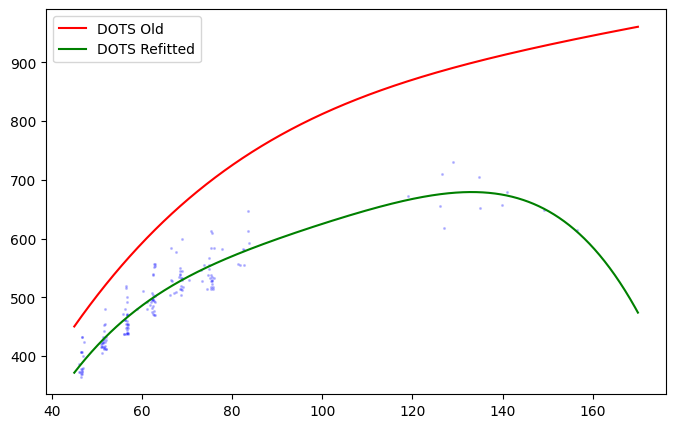

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(bwts, dots(bwts, *dots_p0), c = 'r', label='DOTS Old')
plt.plot(bwts, dots(bwts, *dots_coef), c = 'g', label='DOTS Refitted')
plt.scatter(data['BodyweightKg'].values, data['TotalKg'], alpha=0.2, s = 1.5, color="blue")
plt.legend()

Quite clear that a higher order polynomial is not an appropiate model for this data, as it heavily overfits. Will also be obvious in the relative change graph. 
(Wilks is just DOTS with a 5th order term, so will be even worse. Just add f * x^2 in the formula.)

Text(0, 0.5, '% change in DOTS due to refitting')

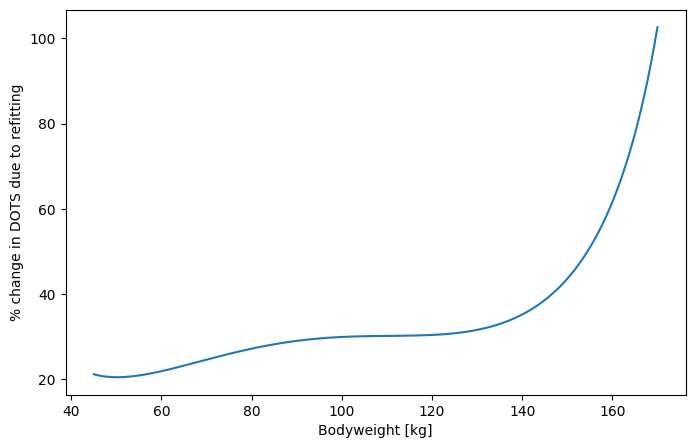

In [17]:
relative_diff = (500 / dots(bwts, *dots_coef)) /  \
    (500 / dots(bwts, *dots_p0))

plt.figure(figsize=(8, 5))
plt.plot(bwts, 100 * (relative_diff-1))
plt.xlabel("Bodyweight [kg]")
plt.ylabel("% change in DOTS due to refitting")

### Weight Class Analysis

In [18]:
data_full['DotsOld'] = data_full['TotalKg'] * (100 / dots(data_full['BodyweightKg'], *dots_p0))
data_full['DotsNew'] = data_full['TotalKg'] * (100 / dots(data_full['BodyweightKg'], *dots_coef))

ValueError: `dataset` input should have multiple elements.

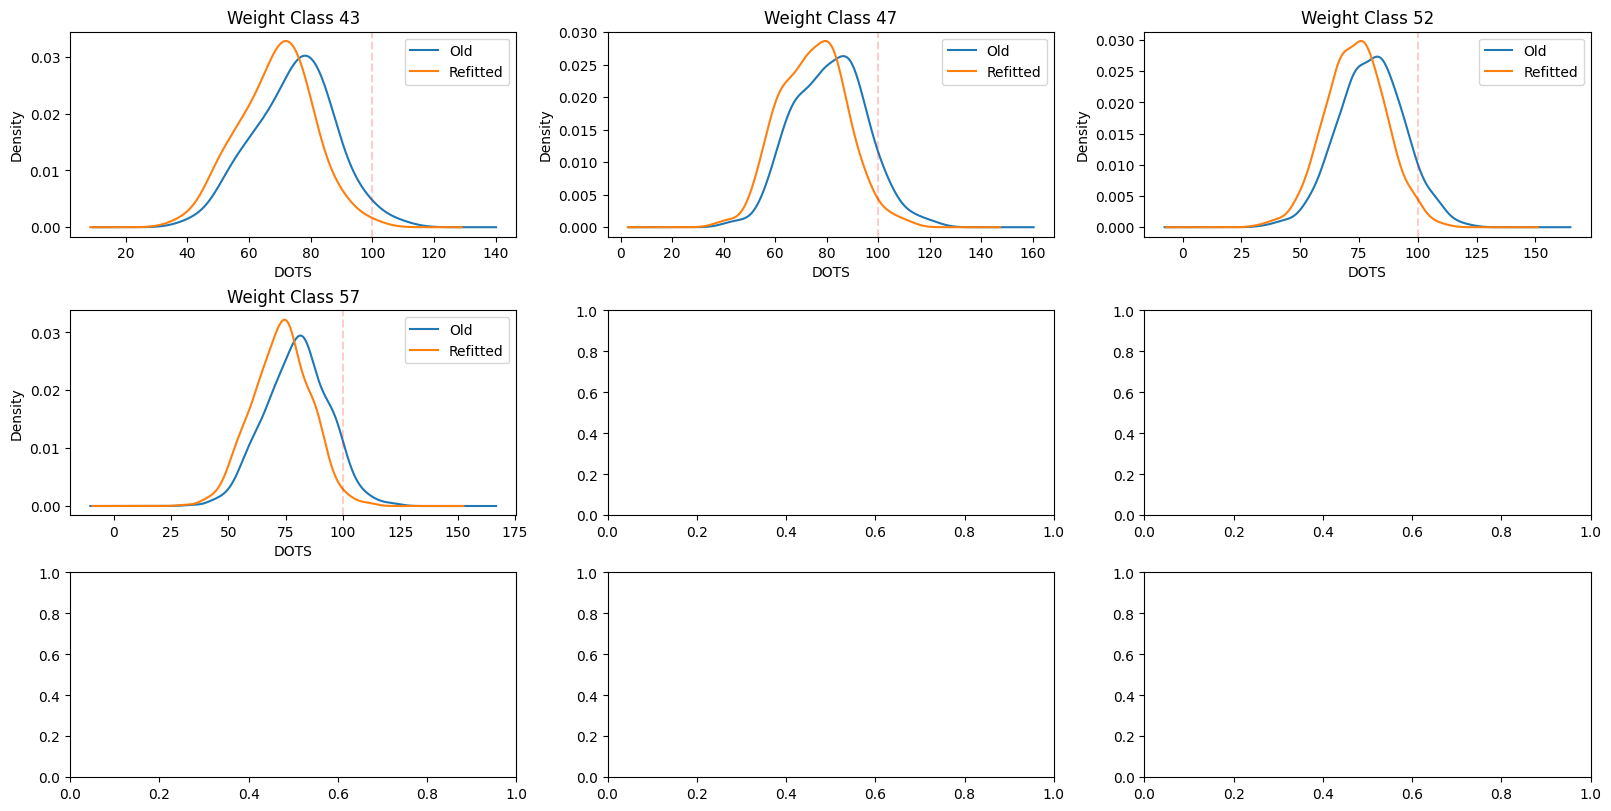

In [19]:
import matplotlib.pyplot as plt

# Define the grid dimensions (here 9 weightclasses, so 3x3)
rows, cols = 3, 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 8), constrained_layout=True)

axes = axes.flatten()

for ax, (weight_class, group) in zip(axes, data_full.groupby('WeightClassKg')):
    group['GLold'].plot(kind='kde', ax=ax, label = 'Old')
    group['GLnew'].plot(kind='kde', ax=ax, label = 'Refitted')
    ax.axvline(100, ymin = 0, color = 'red', linestyle = 'dashed', alpha = 0.2)
    ax.set_title(f'Weight Class {weight_class}')
    ax.set_xlabel('DOTS')
    ax.set_ylabel('Density')
    ax.legend()

plt.show()